### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой мы будем работать в проекте

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [6]:
# напишите запрос
query = '''
SELECT CAST(DATE_TRUNC('month', p.creation_date) AS date) AS creation_month,
       SUM(p.views_count) AS total_views
FROM stackoverflow.posts p
WHERE CAST(DATE_TRUNC('day', p.creation_date) AS date) BETWEEN '2008-01-01' AND '2008-12-31'
GROUP BY CAST(DATE_TRUNC('month', p.creation_date) AS date)
ORDER BY total_views DESC
;
'''

# выполните запрос
monthly_views = pd.read_sql_query(query, con = engine)
monthly_views

,creation_month,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

**Вывод**

Данные за разные месяцы отличаются: сентябрь является безоговорочным лидером по просмотрам, в то время как июль идёт в аутсайдерах. В целом основная активность по просмотрам приходится на осень. Можно предположить, что это связано с началом учебного года, т.к. речь идёт о площадке где обмениваются вопросами и ответами на темы свявзанные с программированием, а значит в обсуждениях принимают участие большое количество обучающихся программированию. 

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [7]:
# напишите запрос
query = '''
WITH t1 AS 
 (SELECT u.id AS user_id,
         u.display_name,
         COUNT(u.display_name) OVER (PARTITION BY u.display_name) AS count_posts,
         COUNT(u.id) OVER (PARTITION BY u.id ORDER BY display_name) AS count_id
 FROM stackoverflow.posts p
 JOIN stackoverflow.post_types pt ON p.post_type_id = pt.id
 JOIN stackoverflow.users u ON p.user_id = u.id
 WHERE pt.type = 'Answer'
 AND p.creation_date BETWEEN u.creation_date AND u.creation_date + INTERVAL '1' MONTH
 ORDER BY 2 DESC
 )
SELECT DISTINCT display_name,
    COUNT(DISTINCT user_id)
FROM t1
WHERE count_posts > 100
GROUP BY 1
ORDER BY 1
;
'''

# выполните запрос
users_activity = pd.read_sql_query(query, con = engine)
display(users_activity, users_activity[users_activity['count'] != 1])

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
71,leppie,1
72,lomaxx,1
73,mattlant,1
74,paxdiablo,1


,display_name,count
4,Alan,8
7,Brian,15
10,Chris,29
12,Craig,10
14,Dan,21
21,Greg,12
25,Jim,7
26,Joe,9
33,Josh,16
34,Keith,5


Какие аномалии наблюдаются в данных? О чём они говорят?

**Вывод**

По имеющимся аномалиям можно предположить, что несколько пользователей могут иметь одинаковые имена. Следовательно, использовать такие данные для анализа не стоит. Лучше использовать уникальные user_id

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [8]:
# напишите запрос
query = '''
WITH t1 AS (
    SELECT DISTINCT u.id
    FROM stackoverflow.users u
    JOIN stackoverflow.posts p ON u.id = p.user_id
    WHERE u.creation_date::date BETWEEN '2008-09-01' AND '2008-09-30'
    AND u.id IN (SELECT DISTINCT p.user_id
                FROM stackoverflow.posts p
                WHERE p.creation_date::date BETWEEN '2008-12-01' AND '2008-12-31')
    )
SELECT CAST(DATE_TRUNC('month', p.creation_date) AS date) AS creation_month,
   COUNT(p.id) AS posts_count
FROM stackoverflow.posts p
JOIN t1 ON p.user_id = t1.id
WHERE CAST(DATE_TRUNC('month', p.creation_date) AS date) BETWEEN '2008-01-01' AND '2008-12-31'
GROUP BY CAST(DATE_TRUNC('month', p.creation_date) AS date)
ORDER BY 1 DESC
;
'''

# выполните запрос
posts_number = pd.read_sql_query(query, con = engine)
posts_number

,creation_month,posts_count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

**Вывод:**

В данных есть посты от пользователей которые зарегистрировались позже даты размещения самого поста. Тут возможны два варианта: 1) это ошибка(произошедшая на этапе записи или выгрузки например); 2) Пост был создан пользователем в режиме гостя(без регистрации), с последующей регистрацией этого пользователя на ресурсе.

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [19]:
# напишите запрос
query = '''
SELECT p.user_id,
    p.creation_date,
    p.views_count,
    SUM(views_count) OVER(PARTITION BY p.user_id ORDER BY p.creation_date)
FROM stackoverflow.posts p
;
'''

# выполните запрос
posts = pd.read_sql_query(query, con = engine)
posts

,user_id,creation_date,views_count,sum
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [10]:
# напишите запрос
query = '''
SELECT DISTINCT p.user_id,
       AVG(p.cnt_as_day) OVER (PARTITION BY p.user_id) AS avg_daily
       FROM (SELECT DISTINCT p.user_id,
            DATE_TRUNC('day', p.creation_date),
            COUNT(*) OVER (PARTITION BY p.user_id, DATE_TRUNC('day', p.creation_date)) AS cnt_as_day,
            COUNT(*) OVER (PARTITION BY p.user_id) AS cnt_all
            FROM stackoverflow.posts as p
            WHERE CAST(DATE_TRUNC('month', p.creation_date) AS date) = '2008-08-01') AS p
WHERE p.cnt_all > 120
ORDER BY 2
;
'''

# выполните запрос
posts_august = pd.read_sql_query(query, con = engine)
posts_august

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [21]:
# напишите запрос
query = '''
WITH t1 AS 
    (SELECT p.user_id,
            p.creation_date::date
    FROM stackoverflow.posts p
    WHERE p.creation_date::date BETWEEN '2008-12-01' AND '2008-12-07'
    GROUP BY 1,2
    ORDER BY 1,2
    ),
        t2 AS 
        (SELECT DISTINCT user_id,
                COUNT(creation_date)
        FROM t1
        GROUP BY 1
        ORDER BY 1
        )
SELECT ROUND(AVG(count), 0) AS result
FROM t2
;
'''

# выполните запрос
result_6 = pd.read_sql_query(query, con = engine)
result_6

,result
0,2.0


**Вывод:**

Видим, что пользователи в среднем взаимодействуют с платформой два раза в неделю

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [22]:
# напишите запрос
query = '''
SELECT user_id,
       creation_date,
    CASE
        WHEN EXTRACT(MONTH FROM last_month) = 1 THEN 'January'
        WHEN EXTRACT(MONTH FROM last_month) = 2 THEN 'February'
        WHEN EXTRACT(MONTH FROM last_month) = 3 THEN 'March'
        WHEN EXTRACT(MONTH FROM last_month) = 4 THEN 'April'
        WHEN EXTRACT(MONTH FROM last_month) = 5 THEN 'May'
        WHEN EXTRACT(MONTH FROM last_month) = 6 THEN 'June'
        WHEN EXTRACT(MONTH FROM last_month) = 7 THEN 'July'
        WHEN EXTRACT(MONTH FROM last_month) = 8 THEN 'August'
        WHEN EXTRACT(MONTH FROM last_month) = 9 THEN 'September'
        WHEN EXTRACT(MONTH FROM last_month) = 10 THEN 'October'
        WHEN EXTRACT(MONTH FROM last_month) = 11 THEN 'November'
        WHEN EXTRACT(MONTH FROM last_month) = 12 THEN 'December'
    END AS second_last_month
FROM (SELECT p.user_id,
             p.creation_date,
             LAG(p.creation_date::date, 2, NULL) OVER (PARTITION BY p.user_id ORDER BY p.creation_date) AS last_month
     FROM stackoverflow.posts p
     ORDER BY 1,2
     ) AS t1
;
'''

# выполните запрос
activity = pd.read_sql_query(query, con = engine)
activity

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [13]:
# напишите запрос
query = '''
WITH profile AS (
        SELECT id, 
               cohort_date, 
               COUNT(id) OVER (PARTITION BY cohort_date) AS user_in_cohort
        FROM (SELECT su.id AS id,
              MIN(DATE_TRUNC('month', sp.creation_date)) AS cohort_date 
              FROM stackoverflow.users su
              JOIN stackoverflow.posts sp ON su.id = sp.user_id
              GROUP BY 1) AS sample
        GROUP BY 1,2
        ),
     session AS (
         SELECT sp.user_id AS id,
                DATE_TRUNC('month', sp.creation_date)::DATE AS session_dt
         FROM stackoverflow.posts sp
         JOIN profile p ON p.id = sp.user_id
         GROUP BY 1,2
         )
SELECT p.cohort_date,
       s.session_dt,
       COUNT(DISTINCT p.id),
       p.user_in_cohort,
       ROUND((COUNT(DISTINCT s.id) * 100.0 / p.user_in_cohort), 2)
FROM profile p
LEFT JOIN session s ON p.id = s.id
GROUP BY 1,2,4
;
'''

# выполните запрос
retention_rate = pd.read_sql_query(query, con = engine)
retention_rate

,cohort_date,session_dt,count,user_in_cohort,round
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Честно говоря, скрипт тут довольно накрученный, но написал ты его безошибочно, молодец!

Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

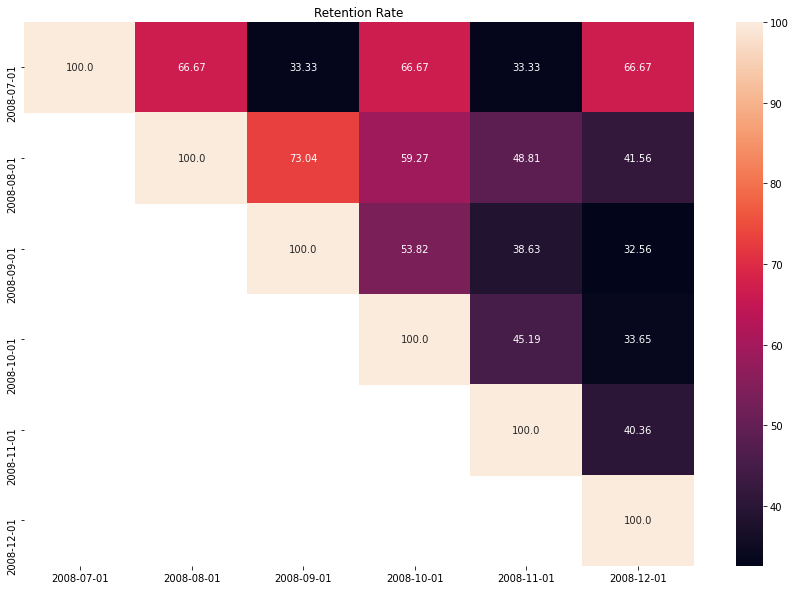

In [14]:
retention = retention_rate.pivot('cohort_date', 'session_dt', 'round')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

plt.figure(figsize = (15, 10))
sns.heatmap(retention,
            annot = True,
            fmt = '')
plt.title('Retention Rate')
plt.show()

**Вывод**

Видим что коэффициент удержания первого дня среди пользователей для когорт в июле, августе и сентябре больше 50%. При этом когорта опубликовавших пост в ноябре имеет самый низкий коэффициент удержания за первый день.

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [15]:
# напишите запрос
query = '''
WITH t1 AS 
    (SELECT DISTINCT EXTRACT(MONTH FROM p.creation_date::date) AS creation_month,
            COUNT(*) OVER (PARTITION BY EXTRACT(MONTH FROM p.creation_date::date)) AS post_count
    FROM stackoverflow.posts p
    WHERE p.creation_date::date BETWEEN '2008-09-01' AND '2008-12-31'
    )
SELECT *,
       ROUND((CAST(post_count AS numeric) / LAG(post_count) OVER (ORDER BY creation_month) - 1) * 100, 2) AS percentage
FROM t1
ORDER BY creation_month
;
'''

# выполните запрос
percentage = pd.read_sql_query(query, con = engine)
percentage

,creation_month,post_count,percentage
0,9.0,70371,NaN
1,10.0,63102,-10.33
2,11.0,46975,-25.56
3,12.0,44592,-5.07


Постройте круговую диаграмму с количеством постов по месяцам.

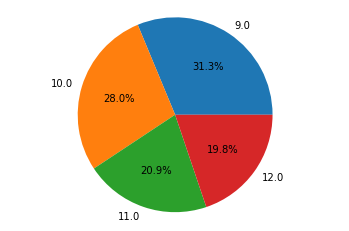

In [16]:
fig, ax = plt.subplots()
ax.pie(percentage['post_count'], 
       labels = percentage['creation_month'], 
       autopct = '%1.1f%%')
ax.axis("equal");

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Да, тут все снова абсолютно точно

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [17]:
# напишите запрос
query = '''
WITH t1 AS 
    (SELECT DISTINCT p.user_id,
            COUNT(p.id)
    FROM stackoverflow.posts p
    GROUP BY 1
    ),
        t2 AS 
            (SELECT user_id
            FROM t1
            WHERE count IN (SELECT MAX(count) FROM t1)
            )
SELECT DISTINCT EXTRACT(WEEK FROM creation_date::date),
       MAX(creation_date) OVER (PARTITION BY EXTRACT(WEEK FROM creation_date::date))
FROM stackoverflow.posts p
JOIN t2 ON p.user_id = t2.user_id
WHERE creation_date::date BETWEEN '2008-10-01' AND '2008-10-31'
;
'''

# выполните запрос
result_10 = pd.read_sql_query(query, con = engine)
result_10

,date_part,max
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01


# Общий вывод

Для начала стоит сказать, что перед тем как делать выводы на основе имеющихся данных следует учесть тот факт, что данные являются не вполне обработанными. Следовательно, в датафрейме имеется ряд особенностей, которые могут исказить результаты исследований. Например наличие постов опубликованных пользователем раньше, чем он(пользователь) зарегистрировался на ресурсе.

Что же мы всётаки можем увидеть в нашей выгрузке:
- видим намёк на сезонность (рост активности пользователей в конце лета - начале осени);
- по первой неделе декабря 2008 года можно сделать вывод, что в среднем пользователь взаимодействует с платформой 2 раза в неделю. Такой способ проверки активности пользователей платформы за опреджелённый период в дальнейшем может быть крайне полезен;
- тут мы доходим до аналога Retention Rate по месяцам для пользователей. Благодаря этой метрике видим, что коэффициент удержания первого дня среди пользователей для когорт в июле, августе и сентябре находится на отметке выше 50%. Чего не скажешь о когорте пользователей с публикациями в ноябре;
- мы снова видим, что сентябрь является абсолютным рекордсменом среди осеннего пика активности, однако количество публикаций неукоснительно падает в последующие месяцы;
- напоследок мы нашли пользователя, который опубликовал больше всего постов и отобразите данные только о последних постах пользователя.

**В целом мы имеем разные выгрузки данных из имеющегося датафрейма, которые можно использовать для дальнейших исследований под конкретные задачи!**